In [1]:
import torch
import lightning.pytorch as pl
from torch.utils.data import DataLoader
from torchgeo.trainers import RegressionTask
from torchgeo.datasets import BoundingBox, stack_samples
from torchgeo.samplers import RandomGeoSampler, PreChippedGeoSampler
from torchgeo.models import ResNet50_Weights

import geopandas as gpd
import ee

from forestsegnet2.datasets import eMapRAGB, GEELandsat8, DatasetStats
from forestsegnet2.datamodules import AGBRegressionDataModule
from forestsegnet2.datasets import GPDFeatureCollection

In [2]:
# Suppress rasterio errors while reading geotiffs
# see https://stackoverflow.com/a/74136171/1913361
from osgeo import gdal

gdal.PushErrorHandler("CPLQuietErrorHandler")

0

In [3]:
TILES80x80 = "../data/vector/tiles_80x80.geojson"
tiles = GPDFeatureCollection(TILES80x80)#, sample_size=1000)
input_args = {"landsat8": dict(year=2018, path="../data/training/geelandsat8", download=True)}
mask_args = {"agb": dict(year=2018, paths="../data/geodatasets/emapr/biomass")}
dm = AGBRegressionDataModule(
    tiles.data,
    batch_size=5,
    patch_size=64,
    num_workers=1,
    mask_args=mask_args,
    input_args=input_args,
)
dm.prepare_data()
dm.setup("fit")

GEELandsat8 stats already exists, collecting stats from file. Set `overwrite=True` to replace. 
eMapRAGB stats already exists, collecting stats from file. Set `overwrite=True` to replace. 


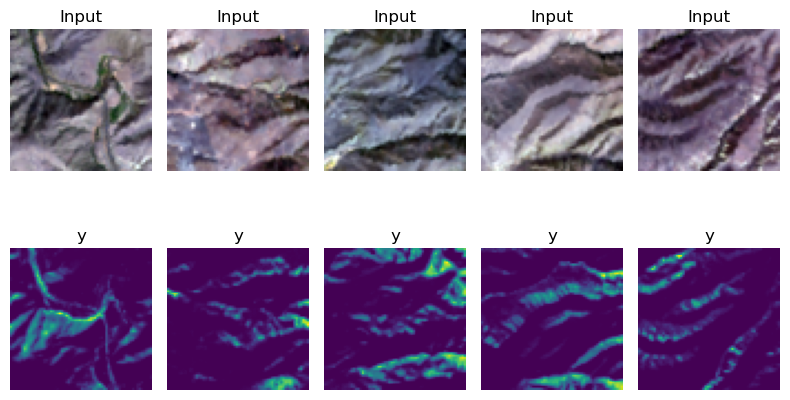

In [4]:
batch = next(iter(dm.train_dataloader()))
dm.plot(batch);

In [6]:
batch['image'].shape#flatten(2).shape


torch.Size([5, 7, 64, 64])

In [7]:
mins = batch['image'].flatten(start_dim=2).min(0).values.flatten()

In [8]:
maxs = batch['image'].flatten(start_dim=2).max(0).values.flatten()

In [16]:
dm.mask_stats

{'mean': tensor([109.3136], dtype=torch.float64),
 'std': tensor([117.7879], dtype=torch.float64),
 'nodata': -32768,
 'samples': 28163}

In [9]:
print(batch["image"].shape)
print(batch["image"].min(), batch["image"].max())

torch.Size([5, 7, 64, 64])
tensor(-1.7063) tensor(3.0059)


In [13]:
batch["mask"].max()

tensor(-0.9281)

In [14]:
batch["mask"].min()

tensor(-0.9281)

In [5]:
import kornia as K

In [15]:
dm.mask_denormalizer(batch["mask"]).max()

tensor(1.5259e-05)

In [39]:
img_0 = K.enhance.normalize_min_max(batch["image"][0], mins[0].item(), maxs[0].item())

In [40]:
img_0 = K.enhance.AdjustContrast(0.7)(img_0)

In [41]:
from rasterio.plot import show

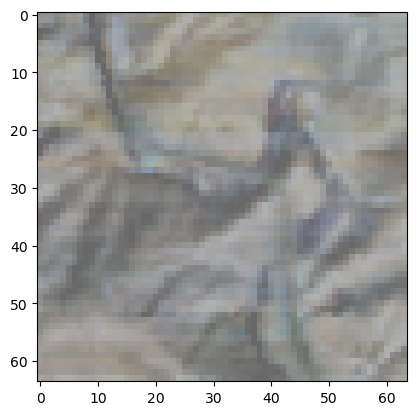

<Axes: >

In [42]:
show(img_0[:3].numpy())

In [8]:
K.tensor_to_image(batch["image"]).shape

(5, 64, 64, 7)

In [ ]:
ee.Initialize()

In [ ]:
agb = eMapRAGB(paths='../data/geodatasets/emapr/biomass')
landsat = GEELandsat8(tiles=tiles[:100], year=2018)#, path='../data/dev/landsat8', download=True)
ds = agb & landsat

In [ ]:
agb.bands

In [ ]:
landsat.paths

In [ ]:
sampler = PreChippedGeoSampler(landsat)

In [ ]:
lst_stats = DatasetStats(ds, sampler, batch_size=10, num_workers=10)
lst_stats.compute()

In [ ]:
def collate_fn(batch):
    new_batch = stack_samples(batch)
    return {'label': new_batch['mask'], 'image': new_batch['image']}

In [ ]:
weights = ResNet50_Weights.LANDSAT_OLI_SR_MOCO

In [ ]:
sampler = RandomGeoSampler(ds, size=240, length=100)
train_dataloader = DataLoader(ds, batch_size=10, sampler=sampler, collate_fn=collate_fn)

In [ ]:
for batch in train_dataloader:
    print(batch['image'].shape, batch['label'].shape)
    break

In [ ]:
task = RegressionTask(
    in_channels=6, 
    num_outputs=1, 
    weights=weights,
    loss='mse', 
    lr=1e-4, 
    patience=5,
)

In [ ]:
trainer = pl.Trainer(
    default_root_dir="../logs",
    accelerator="gpu",
    devices=[0,1,2],
    min_epochs=10,
    max_epochs=20,
    log_every_n_steps=10
)

In [ ]:
trainer.fit(task, train_dataloader)